In [1]:
# !pip install openai
# !pip install ultralytics
# !pip install python-dotenv
# !pip install opencv-python
# !pip install matplotlib
# !pip install pillow
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install scipy
# !pip install seaborn
# !pip install tqdm
# !pip install sahi

In [114]:
import os
from ultralytics import YOLO
import cv2
import numpy as np 
from PIL import Image
from pathlib import Path
from openai import OpenAI
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import io
import base64
from typing import Tuple, Optional, Dict, List, Union


In [112]:
MODEL_NAME_n = "yolo11n.pt"
MODEL_NAME_m = "yolo11m.pt"
MODEL_NAME_x = "yolo11x.pt"
MODEL_NAME_s = "yolo11s.pt"
model = YOLO(MODEL_NAME_x)

def detect(
        image: np.ndarray, 
        padding: int = 20,
        extra_padding: int = 100,  # New parameter for additional padding
        conf_threshold: float = 0.25, 
        iou_threshold: float = 0.5
        )-> list:
    """
    Perform object detection on the given image using the YOLO model.
    Only returns 'person' objects, with additional padding on the bounding box.

    Args:
        image (np.ndarray): Input image as a numpy array.
        padding (int): Number of pixels to expand the bounding box in all directions.
        extra_padding (int): Additional padding for creating larger crops.
        conf_threshold (float): Confidence threshold for detections (0-1).
        iou_threshold (float): IoU threshold for NMS (0-1).

    Returns:
        list: A list of detected 'person' objects, each as a dictionary
              containing label, confidence, and padded bounding box coordinates.
    """
    height, width = image.shape[:2]

    # Perform inference with configurable thresholds
    results = model.predict(
        source=image,
        conf=conf_threshold,
        iou=iou_threshold,
        show_labels=True,
        show_conf=True,
        imgsz=640,
    )   
    
    result = results[0]
    objects = []

    for xyxy, conf, cls in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
        label = model.names[int(cls)]

        # Filter: Keep only 'person'
        if label != "person":
            continue

        # Extract coordinates
        left, top, right, bottom = xyxy.cpu().numpy().astype(int)

        # Apply standard padding, ensuring we stay within image bounds
        left_padded = max(left - padding, 0)
        top_padded = max(top - padding, 0)
        right_padded = min(right + padding, width - 1)
        bottom_padded = min(bottom + padding, height - 1)
        
        # Apply extra padding for larger crops (if specified)
        left_extra = max(left_padded - extra_padding, 0)
        top_extra = max(top_padded - extra_padding, 0)
        right_extra = min(right_padded + extra_padding, width - 1)
        bottom_extra = min(bottom_padded + extra_padding, height - 1)

        # Append result
        objects.append({
            "label": label,
            "confidence": conf.item(),
            "box": [left_padded, top_padded, right_padded, bottom_padded],
            "box_large": [left_extra, top_extra, right_extra, bottom_extra]  # Add larger box
        })

    return objects

In [113]:
# Process video: sample one frame every N seconds, save cropped detections
def process_video(video_path, output_folder, frame_interval_seconds=3, confidence_threshold=0.5):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)  # Frame rate (frames per second)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    print(f"Video FPS: {fps}")
    print(f"Total frames: {total_frames}")
    print(f"Duration (s): {duration}")

    frame_interval = int(fps * frame_interval_seconds)
    frame_number = 0
    crop_counter = 0

    results_list = []

    while frame_number < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if not ret:
            print(f"Failed to read frame at {frame_number}.")
            break

        # Convert BGR to RGB for detect() function
        # rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb_frame = frame

        # #save frame to file
        # save_path = os.path.join(output_folder, f"frame_{frame_number:06d}.jpg")
        # cv2.imwrite(save_path, frame)

        # Run detection
        detections = detect(rgb_frame)
        print(f"Frame {frame_number} ({frame_number/fps:.2f}s): {len(detections)} detections")

        for i, det in enumerate(detections):
            if det['confidence'] < confidence_threshold:
                continue

            x1, y1, x2, y2 = det['box']
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            h, w = rgb_frame.shape[:2]
            x1 = max(0, min(x1, w-1))
            x2 = max(0, min(x2, w-1))
            y1 = max(0, min(y1, h-1))
            y2 = max(0, min(y2, h-1))

            # Save larger cropped image if available
            if 'box_large' in det:
                x1_large, y1_large, x2_large, y2_large = det['box_large']
                x1_large = max(0, min(x1_large, w-1))
                x2_large = max(0, min(x2_large, w-1))
                y1_large = max(0, min(y1_large, h-1))
                y2_large = max(0, min(y2_large, h-1))
                
                # Create the larger crop
                cropped_large = rgb_frame[y1_large:y2_large, x1_large:x2_large, :]
                
                # Save larger cropped image
                save_path_large = os.path.join(output_folder, f"crop_large_frame{frame_number:06d}_det{i:02d}.jpg")
                cv2.imwrite(save_path_large, cropped_large)

            # Save cropped image to Drive folder
            cropped = rgb_frame[y1:y2, x1:x2, :]
            save_path = os.path.join(output_folder, f"crop_frame{frame_number:06d}_det{i:02d}.jpg")
            cv2.imwrite(save_path, cropped)

            crop_counter += 1

            results_list.append({
                "frame_number": frame_number,
                "timestamp": frame_number / fps,
                "box": det["box"],
                "confidence": det["confidence"],
                "saved_path": save_path,
                "detected_objects": detections
            })

        frame_number += frame_interval

    cap.release()
    print(f"Video processing completed — saved {crop_counter} cropped detections.")
    return results_list


In [ ]:
cut_frames = process_video("/home/anhphamquoc/Workspace/VerysellAI/activity-labelling/data/input/class_cut.mp4", output_folder='/home/anhphamquoc/Workspace/VerysellAI/activity-labelling/notebook/output_cut_final/')

In [118]:
# Load environment variables from .env file
load_dotenv()

# Get API key from environment variable
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("OPENAI_API_KEY environment variable not set")

# Initialize OpenAI client
client = OpenAI(api_key=api_key)

In [120]:
def preprocess_image_openai(
    image: np.ndarray, target_size: Tuple[int, int] = (1024, 1024)
) -> np.ndarray:
 
    # Validate target size (both dimensions should be multiples of 32)
    if target_size[0] % 32 != 0 or target_size[1] % 32 != 0:
        print(f"Warning: Target size {target_size} is not a multiple of 32. This may affect model performance.")
    
    # Get original dimensions
    h, w = image.shape[:2]
    
    # Create a black canvas of target size
    canvas = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
    
    # Calculate scaling factor to preserve aspect ratio
    scale = min(target_size[0]/w, target_size[1]/h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Resize image
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # Calculate position to paste (center)
    x_offset = (target_size[0] - new_w) // 2
    y_offset = (target_size[1] - new_h) // 2
    
    # Place the resized image on the canvas
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

    return canvas

In [121]:
def encode_image_to_base64(image_path):
    """
    Encode an image file to base64 string
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        str: Base64 encoded image string
    """
    import base64
    
    # Read the image
    image = cv2.imread(image_path)
    
    # Preprocess the image for better analysis
    processed_image = preprocess_image_openai(image)
    
    # Convert the processed image to bytes
    _, buffer = cv2.imencode('.jpg', processed_image)
    
    # Encode to base64
    return base64.b64encode(buffer).decode('utf-8')

def detect_student_activity(image_path, padded_image_path):
    """
    Detect student activity in an image using OpenAI's Vision API
    
    Args:
        image_path (str): Path to the image file
    
    Returns:
        str: Detected activity
    """
    # Check if image exists
    if not Path(image_path).exists():
        raise FileNotFoundError(f"Image file not found: {image_path}")
    
    # Encode image to base64
    base64_image = encode_image_to_base64(image_path)
    padded_base64_image = encode_image_to_base64(padded_image_path)
    
    # List of activities to detect
    activities = [
        "eating_drinking",
        "sleeping_lying",
        "using_phone",
        "using laptop",
        "standing",
        "talking",
        "writing_reading",
        "sitting_attentively"
    ]
    
    # Prepare the prompt for OpenAI
    prompt = f"""
    You are analyzing two related images of a student:
    - Image 1: a tightly cropped focus image of the student’s upper body or face.
    - Image 2: a larger padded image that shows more context around the student.

    Your goal is to determine the single most prominent activity the student is engaged in from the following list:
    [{', '.join(activities)}]

    Guidelines:
    - Carefully compare both images to get the best context.
    - Choose only one activity label from the list.
    - Do not add any extra explanation or words — only output the activity label exactly as given above.
    - If multiple activities are visible, pick the one that best describes what the student is primarily doing.
    """
    # Call OpenAI API
    response = client.chat.completions.create(
        model="gpt-4.1",  # Use the vision model
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        },
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{padded_base64_image}"
                        },
                        
                    }
                ]
            }
        ],
        max_tokens=50   
    )
    
    # Extract and return the detected activity
    detected_activity = response.choices[0].message.content.strip().lower()
    
    return detected_activity


In [122]:
import os
import pandas as pd
from pathlib import Path
from tqdm import tqdm

def process_image_folder(folder_path):
    """
    Process all pairs of cropped images in a folder
    
    Args:
        folder_path (str): Path to folder containing image pairs
        
    Returns:
        pd.DataFrame: DataFrame with image paths and detected activities
    """
    folder = Path(folder_path)
    results = []
    
    # Get all files in the folder
    all_files = os.listdir(folder)
    
    # Find all regular crop images
    crop_images = [f for f in all_files if f.startswith("crop_frame") and not f.startswith("crop_large_")]
    
    print(f"Found {len(crop_images)} cropped images to process")
    
    for crop_image in tqdm(crop_images):
        # Construct the expected name for the larger cropped version
        base_name = crop_image.replace("crop_", "")
        large_crop_image = f"crop_large_{base_name}"
        
        # Skip if the larger version doesn't exist
        if large_crop_image not in all_files:
            print(f"Warning: No matching large crop found for {crop_image}")
            continue
        
        # Full paths
        crop_path = str(folder / crop_image)
        large_crop_path = str(folder / large_crop_image)
        
        try:
            # Detect activity
            activity = detect_student_activity(crop_path, large_crop_path)
            
            # Store result
            results.append({
                "image": crop_image,
                "large_image": large_crop_image,
                "activity": activity
            })
        except Exception as e:
            print(f"Error processing {crop_image}: {str(e)}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results to CSV in the same folder
    csv_path = folder / "activity_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")
    
    return results_df

# Example usage
folder_path = "/home/anhphamquoc/Workspace/VerysellAI/activity-labelling/notebook/output_cut_final"
results = process_image_folder(folder_path)
results.head()

Found 177 cropped images to process


100%|██████████| 177/177 [06:03<00:00,  2.05s/it]

Results saved to /home/anhphamquoc/Workspace/VerysellAI/activity-labelling/notebook/output_cut_final/activity_results.csv


,image,large_image,activity
0,crop_frame001350_det01.jpg,crop_large_frame001350_det01.jpg,sleeping_lying
1,crop_frame000975_det05.jpg,crop_large_frame000975_det05.jpg,using_laptop
2,crop_frame000675_det02.jpg,crop_large_frame000675_det02.jpg,sitting_attentively
3,crop_frame001275_det07.jpg,crop_large_frame001275_det07.jpg,sitting_attentively
4,crop_frame000075_det06.jpg,crop_large_frame000075_det06.jpg,sitting_attentively


In [105]:
# Function to display image and its detected activity
def display_image_with_activity(image_path, padded_image_path):
    """
    Display an image along with its detected activity
    
    Args:
        image_path (str): Path to the image file
    """
    # Detect activity
    activity = detect_student_activity(image_path, padded_image_path)
    
    # Display image
    img = Image.open(image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(f"Detected Activity: {activity.upper()}")
    plt.axis('off')
    plt.show()
    
    return activity


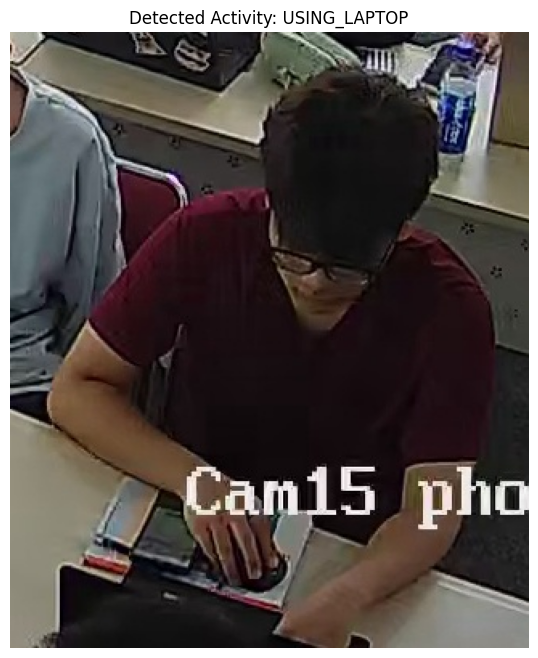

'using_laptop'

In [123]:
# Example usage (replace with your own image path)
image_path = "/home/anhphamquoc/Workspace/VerysellAI/activity-labelling/notebook/output_cut_final/crop_frame000150_det01.jpg"
padded_image_path = "/home/anhphamquoc/Workspace/VerysellAI/activity-labelling/notebook/output_cut_final/crop_large_frame000150_det01.jpg"
display_image_with_activity(image_path, padded_image_path)


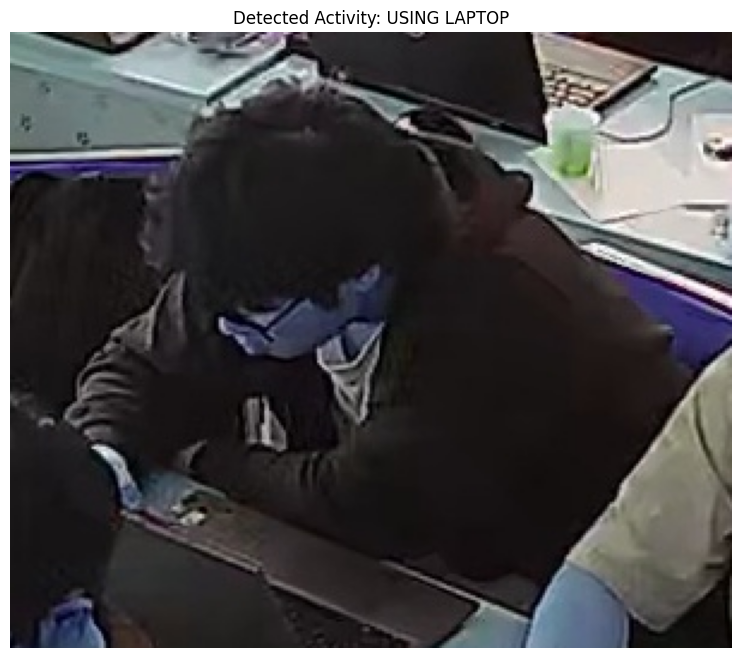

'using laptop'

In [91]:

image_path = "/home/anhphamquoc/Workspace/VerysellAI/activity-labelling/notebook/test_output_no_rgb/crop_frame000375_det03.jpg"
padded_image_path = "/home/anhphamquoc/Workspace/VerysellAI/activity-labelling/notebook/test_output_no_rgb/frame_000000.jpg"
display_image_with_activity(image_path, padded_image_path)

